In [ ]:
# this has implementations of evaluation metrics, but each model is only run once (with fixed seed)

In [79]:
# Set seed
SEED = 3
import random
import numpy as np
import tensorflow as tf # tf backend

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Imports
from danlp.models.embeddings  import load_wv_with_gensim
from gensim.models import KeyedVectors
import json
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model
import matplotlib.pyplot as plt
import nltk
import os
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import utils

## Load data

In [80]:
# Load data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = utils.load_dkhate(test_size=0.2)

pd.DataFrame([X_train_orig, y_train_orig]).T.tail()

,tweet,label
id,,
2378,Hørt!,0
1879,Min reaktion hvis jeg var Svensker,0
42,hey champ Vil du ikke smide et link til hvor d...,0
457,Hvis du melder en for vold eller voldtægt og d...,1
3108,"Vi betaler for omkring 4mb ned, 500kb op men f...",0


## EDA

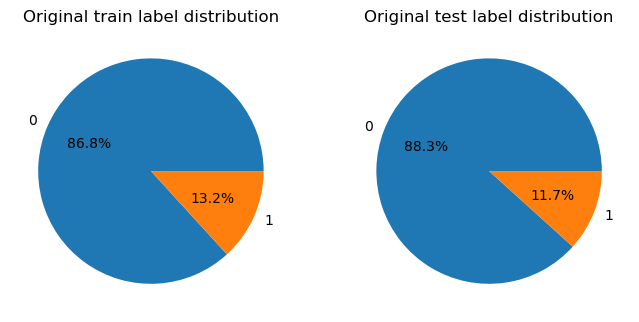

In [81]:
# plot label distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].pie(y_train_orig.value_counts().values,
        labels = y_train_orig.value_counts().index,
        autopct='%1.1f%%')
axes[0].set_title("Original train label distribution")

axes[1].pie(y_test_orig.value_counts().values,
        labels = y_test_orig.value_counts().index,
        autopct='%1.1f%%')
axes[1].set_title("Original test label distribution")

plt.savefig("plots/original_label_distributions.png")
plt.show()

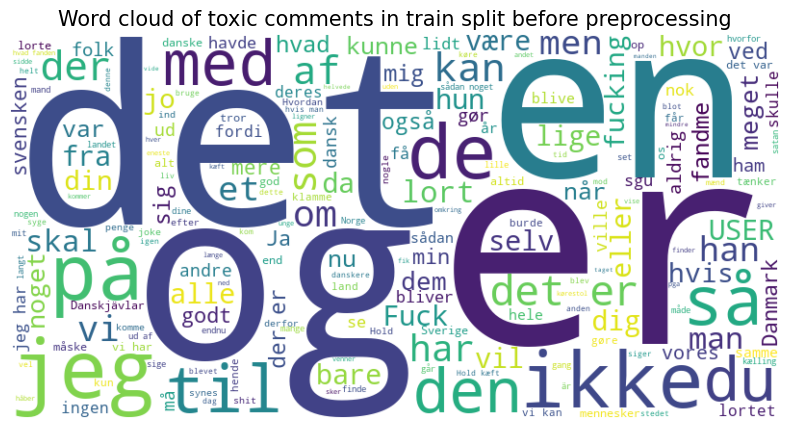

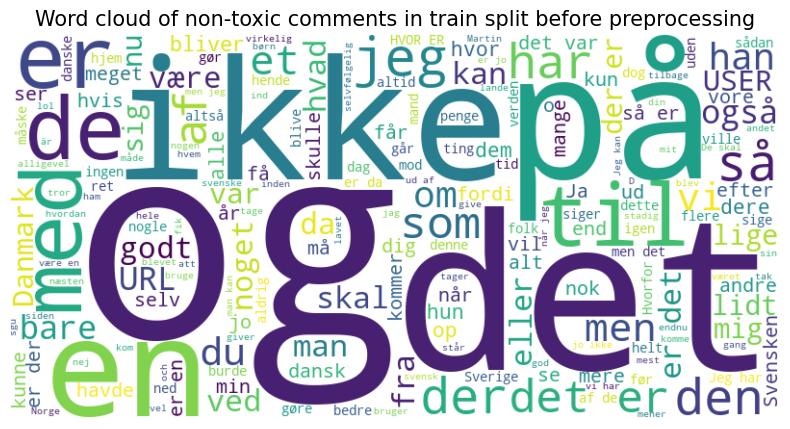

In [82]:
# plot word clouds
utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_orig, y_train_orig, mask=1), title="Word cloud of toxic comments in train split before preprocessing",
    save=True, file_name="toxic_cloud_before_preprocessing.png"
    )

utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_orig, y_train_orig, mask=0), 
    title="Word cloud of non-toxic comments in train split before preprocessing",
    save=True, file_name="nontoxic_cloud_before_preprocessing.png"
    )

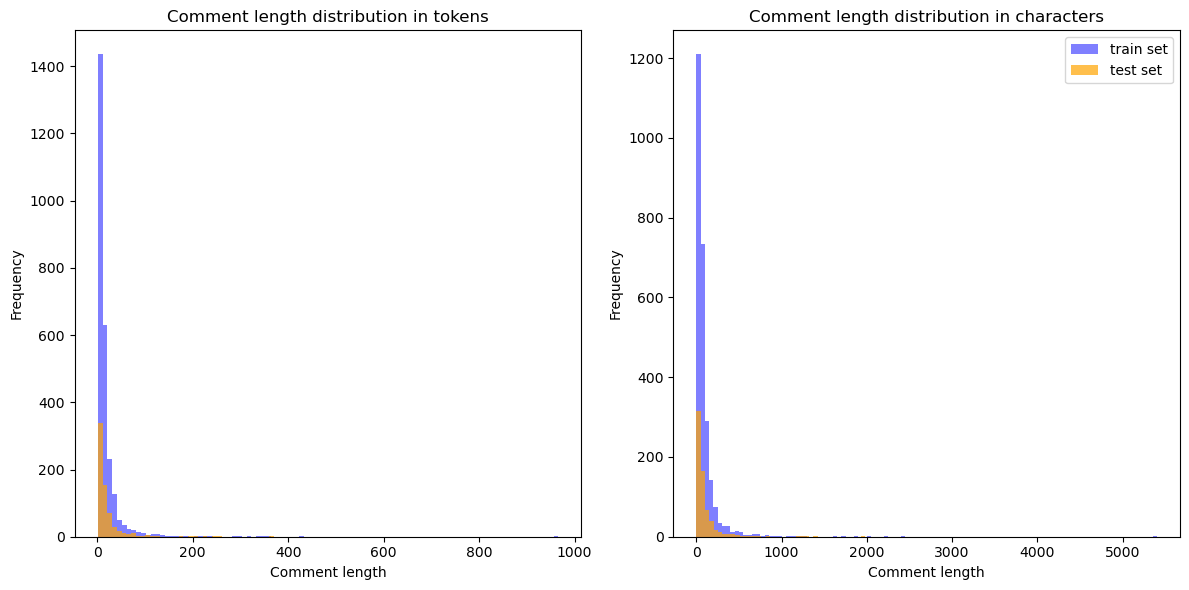

max length of tweet

         non-toxic    toxic
test:    370 words    253 words
train:   966 words    432 words


In [83]:
# plot the distribution of the length of the comments for both toxic and non-toxic classes

# calculate word lengths of both train and test set
tweet_wlengths_train = [len(tweet.split()) for tweet in X_train_orig]
tweet_wlengths_test = [len(tweet.split()) for tweet in X_test_orig]

# calculate char lengths of both train and test set
tweet_clengths_train = [len(tweet) for tweet in X_train_orig]
tweet_clengths_test = [len(tweet) for tweet in X_test_orig]

# plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(tweet_wlengths_train, bins=max(tweet_wlengths_train)//10, color='blue', alpha=0.5, label='train set')
plt.hist(tweet_wlengths_test, bins=max(tweet_wlengths_test)//10, color='orange', alpha=0.7, label='test set')
plt.title('Comment length distribution in tokens')
plt.xlabel('Comment length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(tweet_clengths_train, bins=max(tweet_clengths_train)//50, color='blue', alpha=0.5, label='train set')
plt.hist(tweet_clengths_test, bins=max(tweet_clengths_test)//50, color='orange', alpha=0.7, label='test set')
plt.title('Comment length distribution in characters')
plt.xlabel('Comment length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.legend()
plt.savefig("plots/comment_lengths.png")
plt.show()

# print max lengths
tweet_wlengths_toxic_train = [len(tweet.split()) for tweet in X_train_orig[y_train_orig==1]]
tweet_wlengths_nontoxic_train = [len(tweet.split()) for tweet in X_train_orig[y_train_orig==0]]
tweet_wlengths_toxic_test = [len(tweet.split()) for tweet in X_test_orig[y_test_orig==1]]
tweet_wlengths_nontoxic_test = [len(tweet.split()) for tweet in X_test_orig[y_test_orig==0]]

print("max length of tweet\n")
print("         non-toxic    toxic")
print("test:   ", max(tweet_wlengths_nontoxic_test), "words   ", max(tweet_wlengths_toxic_test), "words")
print("train:  ", max(tweet_wlengths_nontoxic_train), "words   ", max(tweet_wlengths_toxic_train), "words")

## Preprocessing

In [84]:
stop_words = nltk.corpus.stopwords.words('danish')

# preprocess train and test set
X_train_preproc = X_train_orig.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))
X_test_preproc = X_test_orig.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))

print("Before preprocessing:")
display(pd.DataFrame([X_train_orig, y_train_orig]).T.tail())
print(f"Vocab size: {len(utils.get_vocab(X_train_orig, are_tokens=False)):,}")

print("\n\nAfter preprocessing:")
display(pd.DataFrame([X_train_preproc, y_train_orig]).T.tail())
print(f"Vocab size: {len(utils.get_vocab(X_train_preproc, are_tokens=False)):,}")

Before preprocessing:


,tweet,label
id,,
2378,Hørt!,0
1879,Min reaktion hvis jeg var Svensker,0
42,hey champ Vil du ikke smide et link til hvor d...,0
457,Hvis du melder en for vold eller voldtægt og d...,1
3108,"Vi betaler for omkring 4mb ned, 500kb op men f...",0


Vocab size: 13,117


After preprocessing:


,tweet,label
id,,
2378,hørt,0
1879,reaktion svensker,0
42,hey champ smide link ser hearthstone henne,0
457,melder vold voldtægt viser sandt beviser diver...,1
3108,betaler omkring mb kb får nok tættere kb kb be...,0


Vocab size: 8,918


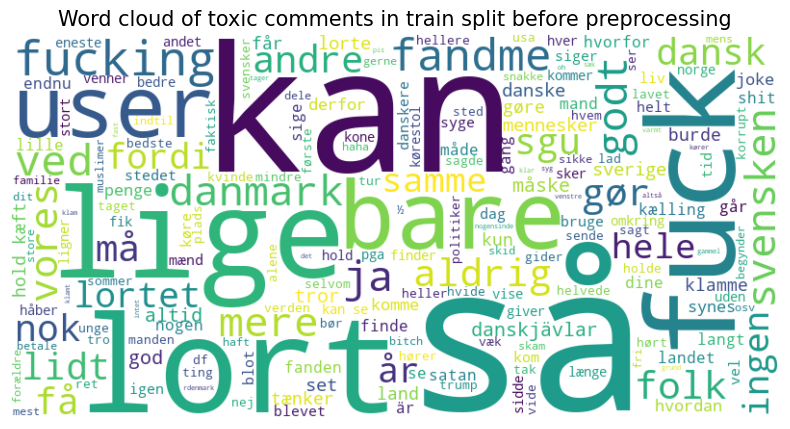

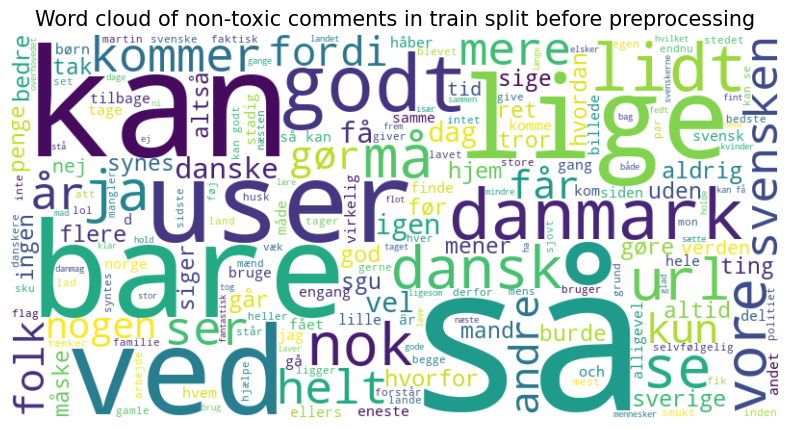

In [85]:
# plot word clouds after preprocessing
utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_preproc, y_train_orig, mask=1), 
    title="Word cloud of toxic comments in train split before preprocessing",
    save=True, file_name="toxic_cloud_after_preprocessing.png"
    )

utils.plot_wordcloud(
    word_cloud=utils.create_wordcloud(X_train_preproc, y_train_orig, mask=0), 
    title="Word cloud of non-toxic comments in train split before preprocessing",
    save=True, file_name="non-toxic_cloud_after_preprocessing.png"
    )

## Prepare data for models

In [86]:
# Ensure that there are no null values
if X_train_preproc.isnull().any() or X_test_preproc.isnull().any():
    raise ValueError("There are missing values in the data.")

# Print shapes
print("Shapes:")
print(X_train_preproc.shape, y_train_orig.shape)
print(X_test_preproc.shape, y_test_orig.shape)

Shapes:
(2631,) (2631,)
(658,) (658,)


In [87]:
# fix class imbalance

# vectorize X_train
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_preproc)

# oversample the minority class
X_train_oversampled, y_train_oversampled = utils.oversample_data(X_train_vec, y_train_orig, strategy=0.5, smote=False) 

# convert back to text
X_train_oversampled = pd.Series([' '.join(vectorizer.inverse_transform(vector)[0]) for vector in X_train_oversampled])

pd.DataFrame([X_train_oversampled, y_train_oversampled]).T.head()

,Unnamed 0,label
0,hahaha,0
1,user føler svært så prøv flytte afrika får str...,0
2,endnu barriere bønder uden eu,0
3,eneste møde ved snuskede stambar aalborg altid...,0
4,godt forøvrigt taget dokumentarprogram svensk ...,0


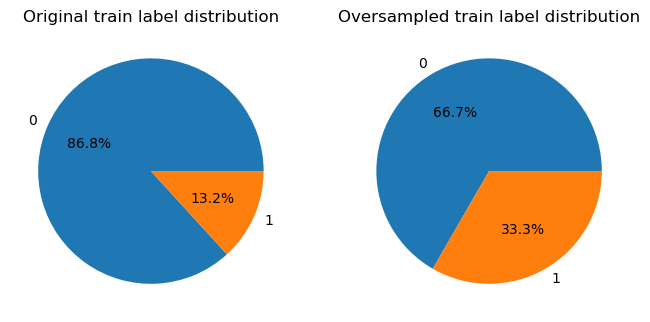

In [88]:
# plot label distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].pie(y_train_orig.value_counts().values,
        labels = y_train_orig.value_counts().index,
        autopct='%1.1f%%')
axes[0].set_title("Original train label distribution")

axes[1].pie(y_train_oversampled.value_counts().values,
        labels = y_train_oversampled.value_counts().index,
        autopct='%1.1f%%')
axes[1].set_title("Oversampled train label distribution")

plt.savefig("plots/new_label_distributions.png")
plt.show()

In [89]:
# pickle the preprocessed and oversampled splits
dataset_splits = {
    "X training preprocessed and oversampled": X_train_oversampled,
    "y training preprocessed and oversampled": y_train_oversampled,
    "X test preprocessed": X_test_preproc,
    "y test": y_test_orig
}

with open("data/dataset_splits.pkl", "wb") as f:
    pickle.dump(dataset_splits, f)

In [90]:
# rename splits (remove suffixes)
X_train = X_train_oversampled
y_train = y_train_oversampled
X_test = X_test_preproc
y_test = y_test_orig

## Baseline model (logistic regression with unigrams)

In [91]:
# vectorization
vectorizer = TfidfVectorizer(ngram_range=(1,1)) # unigrams
vectorizer = vectorizer.fit(X_train)
feat_names = vectorizer.get_feature_names_out()
X_train_baseline = vectorizer.transform(X_train)
X_test_baseline = vectorizer.transform(X_test)

print(f"{len(feat_names):,} unigrams in total (= number of features)\n")
print("First 5 unigrams:")
for unigram in feat_names[:5]:
    print(unigram)

print("\nShapes:")
print(X_train_baseline.shape, y_train.shape)
print(X_test_baseline.shape, y_test.shape)

8,785 unigrams in total (= number of features)

First 5 unigrams:
aa
aaaaah
aaaarg
aaalt
aalborg

Shapes:
(3424, 8785) (3424,)
(658, 8785) (658,)


              precision    recall  f1-score   support

           0       0.91      0.99      0.95       581
           1       0.74      0.22      0.34        77

    accuracy                           0.90       658
   macro avg       0.82      0.61      0.64       658
weighted avg       0.89      0.90      0.87       658



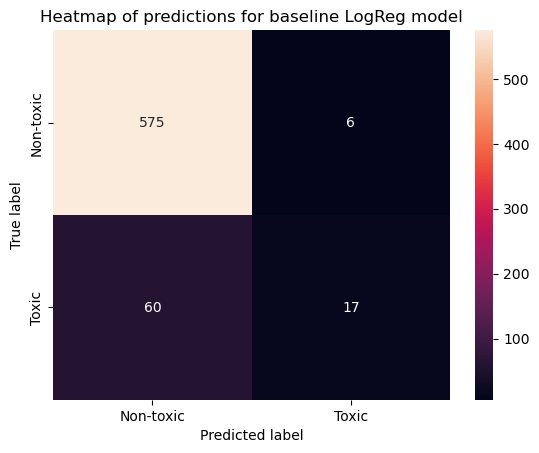

In [92]:
# log reg baseline

# define and fit model
lr = LogisticRegression()
lr.fit(X_train_baseline, y_train)

# make predictions and evaluate model
lr_pred = lr.predict(X_test_baseline)
print(classification_report(y_test, lr_pred))

lr_cm = confusion_matrix(y_test, lr_pred, labels=lr.classes_)
utils.plot_heatmap(lr_cm, title="Heatmap of predictions for baseline LogReg model", save=True, file_name="logreg_heatmap.png")

In [93]:
# save baseline
with open("models/baseline_lr.pkl", "wb") as f:
    pickle.dump(lr, f)

# save vectorized version of X_test
with open("data/X_test_baseline.pkl", "wb") as f:
    pickle.dump(X_test_baseline, f)

## CNN

In [94]:
# prepare data for model

NUM_WORDS = 10000

# tokenization
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

# pad sequences to max length
MAXLEN = max([len(x) for x in X_train_tokenized])
print(f"Max {MAXLEN} tokens in train")
X_train_padded = pad_sequences(X_train_tokenized, maxlen=MAXLEN, padding="post")
X_test_padded = pad_sequences(X_test_tokenized, maxlen=MAXLEN, padding="post")

# check shapes
print("\nShapes:")
print(X_train_padded.shape, y_train.shape)
print(X_test_padded.shape, y_test.shape)

Max 322 tokens in train

Shapes:
(3424, 322) (3424,)
(658, 322) (658,)


In [95]:
# load pre-trained embeddings

# CONLL17 embeddings
if "word2vec.model" not in os.listdir("embeddings") or "word2vec.model.vectors.npy" not in os.listdir("embeddings"):
    word_embeddings = load_wv_with_gensim('conll17.da.wv')
    word_embeddings.save("embeddings/word2vec.model")
word_embeddings = KeyedVectors.load("embeddings/word2vec.model")

# # Wiki embeddings
# if "word2vecwiki.model" not in os.listdir("embeddings") or "word2vecwiki.model.vectors.npy" not in os.listdir("embeddings"):
#     word_embeddings = load_wv_with_gensim('wiki.da.wv')
#     word_embeddings.save("embeddings/word2vecwiki.model")
# word_embeddings = KeyedVectors.load("embeddings/word2vecwiki.model")

In [96]:
# explore embeddings

print("Examples of words in embeddings vocabulary:")
for x in list(word_embeddings.vocab.keys())[:15]:
    print(x) 

print("\n___ is to 'england' as 'københavn' is to 'danmark':")
for x in word_embeddings.most_similar(positive=['københavn', 'england'], negative=['danmark'], topn=3):
    print(x)

print("\n___ is to 'kvinde' as 'dreng' is to 'mand':")
for x in word_embeddings.most_similar(positive=['dreng', 'kvinde'], negative=['mand'], topn=3):
    print(x)

Examples of words in embeddings vocabulary:
</s>
,
.
i
og
af
er
at
til
på
en
med
for
det
-

___ is to 'england' as 'københavn' is to 'danmark':
('london', 0.7156291604042053)
('edinburgh', 0.6790332198143005)
('woolwich', 0.6561343669891357)

___ is to 'kvinde' as 'dreng' is to 'mand':
('pige', 0.8950952291488647)
('skolepige', 0.792621910572052)
('legetøjsfigur', 0.7810863852500916)


In [97]:
# create word to embedding vector map
embeddings_index = {}
for w in word_embeddings.vocab.keys():
    embeddings_index[w] = word_embeddings[w]

In [98]:
# get dimension of embeddings
EMB_DIM = embeddings_index.get('er').shape[0]
print("Embedding dimension:", EMB_DIM)

Embedding dimension: 100


In [99]:
# map words in train to pretrained word embeddings
hits, misses = 0, 0
misses_list = []

embedding_matrix = np.zeros((NUM_WORDS, EMB_DIM)) # empty embedding matrix with zeros
for word, i in tokenizer.word_index.items(): # for each word in training vocab (tokenizer)
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) # put it in the matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        misses_list.append(word)
        
# if a word is not in the pretrained embedding, the entry will remain zero
print(f"Converted {hits:,} words ({misses:,} misses)")

# save misses to txt file
with open('word_embedding_misses.txt', 'w') as f:
    for miss in sorted(misses_list):
        f.write(miss)
        f.write("\n")

Converted 7,794 words (992 misses)


In [100]:
# Define network

cnn = Sequential()
cnn.add(layers.Input(shape=(None,), dtype="int64")) # input layer
cnn.add(layers.Embedding( # embedding layer using pretrained embeddings
    input_dim=NUM_WORDS, 
    output_dim=EMB_DIM, 
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
    trainable=True))

# add layers
cnn.add(layers.Conv1D(128, 5, activation="relu"))
cnn.add(layers.GlobalMaxPooling1D())
cnn.add(layers.Dense(10, activation="relu"))
cnn.add(layers.Dense(1, activation="sigmoid"))

# compile model
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

# summarize model
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,065,429
Trainable params: 1,065,429
Non-trainable params: 0
____________________________________________

In [101]:
# fit model
history = cnn.fit(X_train_padded, y_train, 
                    batch_size=128,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test_padded, y_test))

Epoch 1/10
27/27 [==============================] - 6s 152ms/step - loss: 0.6163 - acc: 0.6522 - val_loss: 0.4508 - val_acc: 0.8830
Epoch 2/10
27/27 [==============================] - 3s 127ms/step - loss: 0.4538 - acc: 0.7742 - val_loss: 0.3717 - val_acc: 0.8891
Epoch 3/10
27/27 [==============================] - 3s 130ms/step - loss: 0.2829 - acc: 0.9127 - val_loss: 0.3112 - val_acc: 0.8921
Epoch 4/10
27/27 [==============================] - 4s 130ms/step - loss: 0.1579 - acc: 0.9562 - val_loss: 0.2870 - val_acc: 0.9012
Epoch 5/10
27/27 [==============================] - 4s 130ms/step - loss: 0.0841 - acc: 0.9784 - val_loss: 0.2891 - val_acc: 0.9012
Epoch 6/10
27/27 [==============================] - 4s 132ms/step - loss: 0.0444 - acc: 0.9930 - val_loss: 0.3165 - val_acc: 0.9058
Epoch 7/10
27/27 [==============================] - 4s 132ms/step - loss: 0.0269 - acc: 0.9965 - val_loss: 0.3263 - val_acc: 0.9058
Epoch 8/10
27/27 [==============================] - 3s 129ms/step - loss: 0.

In [102]:
# save and load model
cnn.save("models/cnn_model.keras") 
cnn = tf.keras.models.load_model("models/cnn_model.keras")

# save vectorized and padded version of X_test
with open("data/X_test_cnn.pkl", "wb") as f:
    pickle.dump(X_test_padded, f)

# save tokenizer
tokenizer_json = tokenizer.to_json()
with open("models/tokenizer.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

# save maxlen value
with open("models/maxlen.txt", "w", encoding="utf-8") as f:
    f.write(str(MAXLEN))

21/21 [==============================] - 0s 8ms/step

               precision    recall  f1-score   support

           0       0.93      0.97      0.95       581
           1       0.65      0.42      0.51        77

    accuracy                           0.91       658
   macro avg       0.79      0.69      0.73       658
weighted avg       0.89      0.91      0.90       658



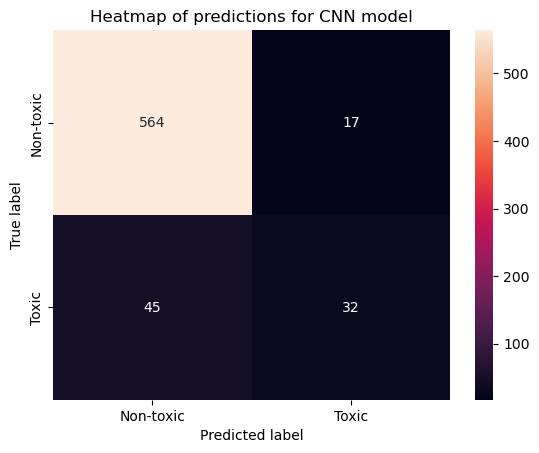

In [103]:
# make predictions
p = cnn.predict(X_test_padded)
pred = np.where(p > .5, 1, 0)

# print classification report and plot heatmap
print("\n", classification_report(y_test, pred))
cnn_cm = confusion_matrix(y_test, pred)
utils.plot_heatmap(cnn_cm, title="Heatmap of predictions for CNN model", save=True, file_name="cnn_heatmap.png")

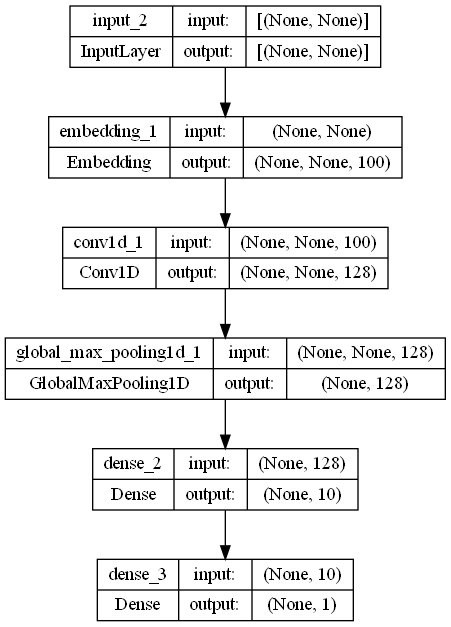

In [104]:
# Plot model
plot_model(cnn,
           to_file="models/cnn_model.png",
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir="TB", # LR = horizontal, TB = vertical
           expand_nested=False,
           dpi=96,
           layer_range=None, # if you only want to plot some layers, specify them here
           show_layer_activations=False
           )

In [105]:
# Predict new sentences using this model

sent = "Kriminelle damer" # change sentence accordingly
proba = utils.predict_toxicity(sent, stop_words, tokenizer, MAXLEN, cnn)
print("Probability:", proba[0])
print("Prediction :", round(proba[0][0]))

1/1 [==============================] - 0s 35ms/step
Probability: [0.7436549]
Prediction : 1


# Evaluation

In [106]:
from sklearn.metrics import roc_auc_score, roc_curve

21/21 [==============================] - 0s 8ms/step


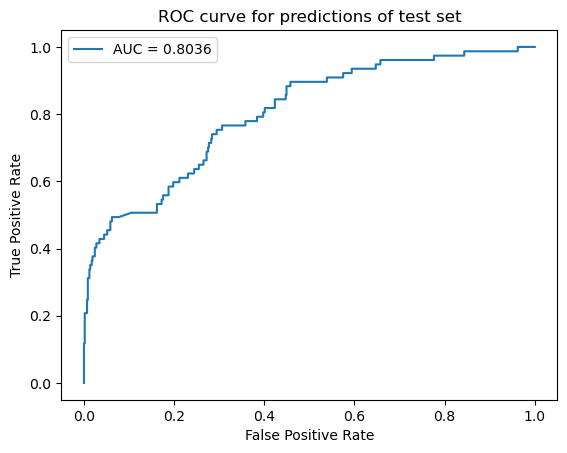

Best Threshold=0.028472, G-Mean=0.729


In [107]:
# ROC and AUC on test set
y_proba = cnn.predict(X_test_padded)

# compute roc curve and auc
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
auc = roc_auc_score(y_test, y_proba)

# plot and save
plt.plot(fpr, tpr, label=f"AUC = {round(auc,4)}")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.title("ROC curve for predictions of test set")
plt.savefig("plots/ROC_AUC_testset.png")
plt.show()

# from https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
gmeans = np.sqrt(tpr*(1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# tried to use this best threshold, but honestly just made it worse (f1 and accuracy)

In [108]:
# yhat = lr.predict_proba(X_test_baseline)
# yhat = yhat[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, yhat, pos_label=1)
# auc = roc_auc_score(y_test, yhat)

# plt.plot(fpr, tpr, label=f"AUC = {round(auc,4)}")
# plt.ylabel("True Positive Rate")
# plt.xlabel("False Positive Rate")
# plt.legend()
# plt.title("ROC curve for predictions of test set (baseline)")
# plt.show()

In [109]:
# ROC curve and AUC for templates

# load synthetic data
synth_data = pd.read_excel("g:/My Drive/ITC, 5th semester (Thesis)/Code/Github_code/create_synthetic_dataset/synthetic_data.xlsx")

# all data
X_synth = synth_data['text']
y_synth = synth_data['toxic']

print(len(X_synth), "sentences")
synth_data.head()

12780 sentences


,text,group,identity_term,toxic
0,kvinder er klamme og generelt bare nederen,F,kvinder,1
1,piger er klamme og generelt bare nederen,F,piger,1
2,damer er klamme og generelt bare nederen,F,damer,1
3,koner er klamme og generelt bare nederen,F,koner,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1


In [110]:
# split by identity group

synth_F = synth_data[synth_data.group == "F"]
synth_M = synth_data[synth_data.group == "M"]
synth_Q = synth_data[synth_data.group == "Q"]

X_synth_F = synth_F.text
y_synth_F = synth_F.toxic

X_synth_M = synth_M.text
y_synth_M = synth_M.toxic

X_synth_Q = synth_Q.text
y_synth_Q = synth_Q.toxic

In [111]:
# all sythetic data

# preprocess synthetic data
X_synth_preproc = X_synth.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))

# tokenize and pad data
X_synth_tokenized = tokenizer.texts_to_sequences(X_synth_preproc)
X_synth_padded = pad_sequences(X_synth_tokenized, MAXLEN, padding="post")

# predict toxicity of synthetic data
synth_proba = cnn.predict(X_synth_padded)

400/400 [==============================] - 4s 9ms/step


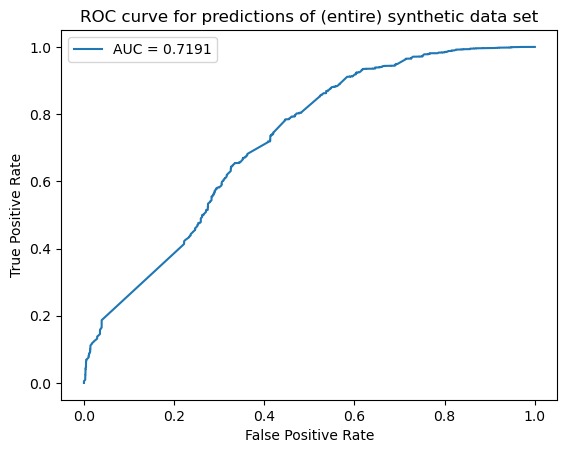

In [112]:
# all synthetic data
# compute roc curve and auc
fpr, tpr, thresholds = roc_curve(y_synth, synth_proba, pos_label=1)
auc = roc_auc_score(y_synth, synth_proba)

# plot and save
plt.plot(fpr, tpr, label=f"AUC = {round(auc,4)}")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.title("ROC curve for predictions of (entire) synthetic data set")
plt.show()

In [35]:
# # per group

# # preprocess synthetic data
# X_synth_F_preproc = X_synth_F.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))
# X_synth_M_preproc = X_synth_M.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))
# X_synth_Q_preproc = X_synth_Q.apply(lambda text: utils.preprocess(text, stopwords=stop_words, to_string=True))

# # tokenize and pad data
# X_synth_F_tokenized = tokenizer.texts_to_sequences(X_synth_F_preproc)
# X_synth_M_tokenized = tokenizer.texts_to_sequences(X_synth_M_preproc)
# X_synth_Q_tokenized = tokenizer.texts_to_sequences(X_synth_Q_preproc)
# X_synth_F_padded = pad_sequences(X_synth_F_tokenized, MAXLEN, padding="post")
# X_synth_M_padded = pad_sequences(X_synth_M_tokenized, MAXLEN, padding="post")
# X_synth_Q_padded = pad_sequences(X_synth_Q_tokenized, MAXLEN, padding="post")

# # predict toxicity of synthetic data
# synth_F_proba = cnn.predict(X_synth_F_padded)
# synth_M_proba = cnn.predict(X_synth_M_padded)
# synth_Q_proba = cnn.predict(X_synth_Q_padded)

134/134 [==============================] - 2s 12ms/step


In [36]:
# # female part of synthetic data
# # compute roc curve and auc
# fpr, tpr, thresholds = roc_curve(y_synth_F, synth_F_proba, pos_label=1)
# auc = roc_auc_score(y_synth_F, synth_F_proba)

# # plot and save
# plt.plot(fpr, tpr, label=f"AUC = {round(auc,4)}")
# plt.ylabel("True Positive Rate")
# plt.xlabel("False Positive Rate")
# plt.legend()
# plt.title("ROC curve for predictions of the female part of the synthetic data set")
# plt.show()

In [37]:
# # male part of synthetic data
# # compute roc curve and auc
# fpr, tpr, thresholds = roc_curve(y_synth_M, synth_M_proba, pos_label=1)
# auc = roc_auc_score(y_synth_M, synth_M_proba)

# # plot and save
# plt.plot(fpr, tpr, label=f"AUC = {round(auc,4)}")
# plt.ylabel("True Positive Rate")
# plt.xlabel("False Positive Rate")
# plt.legend()
# plt.title("ROC curve for predictions of the male part of the synthetic data set")
# plt.show()

In [38]:
# # queer part of synthetic data
# # compute roc curve and auc
# fpr, tpr, thresholds = roc_curve(y_synth_Q, synth_Q_proba, pos_label=1)
# auc = roc_auc_score(y_synth_Q, synth_Q_proba)

# # plot and save
# plt.plot(fpr, tpr, label=f"AUC = {round(auc,4)}")
# plt.ylabel("True Positive Rate")
# plt.xlabel("False Positive Rate")
# plt.legend()
# plt.title("ROC curve for predictions of the queer part of the synthetic data set")
# plt.show()

# Try again

In [ ]:
# def per_subgroup_negative_rates(df, subgroups, model_families, threshold,
#                                 label_col):
#   """Computes per-subgroup true/false negative rates for all model families.

#   Args:
#     df: dataset to compute rates on.
#     subgroups: negative rates are computed on subsets of the dataset
#       containing each subgroup.
#     model_families: list of model families; each model family is a list of
#       model names in the family.
#     threshold: threshold to use to compute negative rates. Can either be a
#       float, or a dictionary mapping model name to float threshold in order to
#       use a different threshold for each model.
#     label_col: column in df containing the boolean label.

#   Returns:
#     DataFrame with per-subgroup false/true negative rates for each model
#     family. Results are summarized across each model family, giving mean,
#     median, and standard deviation of each negative rate.
#   """
#   records = []
#   for subgroup in subgroups:
#     if subgroup is None:
#       subgroup_subset = df
#     else:
#       subgroup_subset = df[df[subgroup]]
#     subgroup_record = {
#         SUBGROUP: subgroup,
#         SUBSET_SIZE: len(subgroup_subset)
#     }
#     for model_family in model_families:
#       family_name = model_family_name(model_family)
#       family_rates = []
#       for model_name in model_family:
#         model_threshold = (
#             threshold[model_name] if isinstance(threshold, dict) else threshold)
#         assert isinstance(model_threshold, float)
#         model_rates = compute_confusion_rates(subgroup_subset, model_name,
#                                               label_col, model_threshold)
#         family_rates.append(model_rates)
#       tnrs, fnrs = ([rates['tnr'] for rates in family_rates],
#                     [rates['fnr'] for rates in family_rates])
#       subgroup_record.update({
#           family_name + '_tnr_median': np.median(tnrs),
#           family_name + '_tnr_mean': np.mean(tnrs),
#           family_name + '_tnr_std': np.std(tnrs),
#           family_name + '_tnr_values': tnrs,
#           family_name + '_fnr_median': np.median(fnrs),
#           family_name + '_fnr_mean': np.mean(fnrs),
#           family_name + '_fnr_std': np.std(fnrs),
#           family_name + '_fnr_values': fnrs,
#       })
#     records.append(subgroup_record)
#   return pd.DataFrame(records)


# def compute_confusion_rates(df, score_col, label_col, threshold):
#   """Compute confusion rates."""
#   confusion = confusion_matrix_counts(df, score_col, label_col, threshold)
#   actual_positives = confusion['tp'] + confusion['fn']
#   actual_negatives = confusion['tn'] + confusion['fp']
#   # True positive rate, sensitivity, recall.
#   tpr = confusion['tp'] / actual_positives
#   # True negative rate, specificity.
#   tnr = confusion['tn'] / actual_negatives
#   # False positive rate, fall-out.
#   fpr = 1 - tnr
#   # False negative rate, miss rate.
#   fnr = 1 - tpr
#   # Precision, positive predictive value.
#   precision = confusion['tp'] / (confusion['tp'] + confusion['fp'])
#   return {
#       'tpr': tpr,
#       'tnr': tnr,
#       'fpr': fpr,
#       'fnr': fnr,
#       'precision': precision,
#       'recall': tpr,
#   }

# def confusion_matrix_counts(df, score_col, label_col, threshold):
#   return {
#       'tp': len(df[(df[score_col] >= threshold) & df[label_col]]),
#       'tn': len(df[(df[score_col] < threshold) & ~df[label_col]]),
#       'fp': len(df[(df[score_col] >= threshold) & ~df[label_col]]),
#       'fn': len(df[(df[score_col] < threshold) & df[label_col]]),
#   }

In [ ]:
# https://github.com/conversationai/unintended-ml-bias-analysis/blob/main/archive/unintended_ml_bias/model_bias_analysis.py#L364
# Dixon's code

# fped, fned

In [72]:
def compute_confusion_counts(y_actual:np.ndarray, y_pred:np.ndarray):
    # return tp, tn, fp, fn
    tp = sum([a==1 and p==1 for (a, p) in zip(y_actual, y_pred)])
    tn = sum([a==0 and p==0 for (a, p) in zip(y_actual, y_pred)])
    fp = sum([a==0 and p==1 for (a, p) in zip(y_actual, y_pred)])
    fn = sum([a==1 and p==0 for (a, p) in zip(y_actual, y_pred)])
    return {"tp":tp, "tn":tn, "fp":fp, "fn":fn}

In [73]:
compute_confusion_counts(y_synth, synth_pred)

{'tp': 635, 'tn': 6302, 'fp': 88, 'fn': 5755}

In [189]:
# TODO check these calculatiosn and synonyms

def compute_confusion_rates(y_actual, y_pred):
    conf_counts = compute_confusion_counts(y_actual, y_pred)
    actually_pos = conf_counts['tp'] + conf_counts['fn']
    actually_neg = conf_counts['tn'] + conf_counts['fp']
    
    # true positive rate = sensitivity = recall
    tpr = conf_counts['tp'] / actually_pos

    # true negative rate = specificity
    tnr = conf_counts['tn'] / actually_neg
    
    # false positive rate = fall-out
    fpr = 1 - tnr
    
    # false negative rate = miss rate
    fnr = 1 - tpr
    
    return {
        "tpr": tpr,
        "tnr": tnr,
        "fpr": fpr,
        "fnr": fnr
    }

In [190]:
compute_confusion_rates(y_synth, synth_pred)

{'tpr': 0.09937402190923318,
 'tnr': 0.9862284820031298,
 'fpr': 0.013771517996870153,
 'fnr': 0.9006259780907668}

In [114]:
# load synth data
synth_data = pd.read_excel("g:/My Drive/ITC, 5th semester (Thesis)/Code/Github_code/create_synthetic_dataset/synthetic_data.xlsx")
synth_data.head()

,text,group,identity_term,toxic
0,kvinder er klamme og generelt bare nederen,F,kvinder,1
1,piger er klamme og generelt bare nederen,F,piger,1
2,damer er klamme og generelt bare nederen,F,damer,1
3,koner er klamme og generelt bare nederen,F,koner,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1


In [115]:
# predict synth data

# tokenize and pad data
X_synth_tokenized = tokenizer.texts_to_sequences(X_synth_preproc)
X_synth_padded = pad_sequences(X_synth_tokenized, MAXLEN, padding="post")

# predict toxicity of synthetic data
synth_data['proba'] = cnn.predict(X_synth_padded)

400/400 [==============================] - 3s 8ms/step


In [121]:
synth_data['pred'] = synth_data['proba'] > 0.5
synth_data['pred'] = synth_data['pred'].astype(int)
synth_data.head()

,text,group,identity_term,toxic,proba,pred
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,0.894911,1
1,piger er klamme og generelt bare nederen,F,piger,1,0.965669,1
2,damer er klamme og generelt bare nederen,F,damer,1,0.900526,1
3,koner er klamme og generelt bare nederen,F,koner,1,0.935275,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,0.960006,1


In [129]:
synth_data.head()

,text,group,identity_term,toxic,proba,pred
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,0.894911,1
1,piger er klamme og generelt bare nederen,F,piger,1,0.965669,1
2,damer er klamme og generelt bare nederen,F,damer,1,0.900526,1
3,koner er klamme og generelt bare nederen,F,koner,1,0.935275,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,0.960006,1


In [172]:
# now calculate per-term fpr

g = synth_data.groupby('identity_term')
fprs = dict()
for i in g:
    g_name = i[0]
    g_df = i[1]
    
    #print(g_name)
    #print(confusion_matrix(g_df['toxic'], g_df['pred']))
    #print(compute_confusion_counts(y_actual=g_df['toxic'], y_pred=g_df['pred']))
    
    g_confusion_rates = compute_confusion_rates(y_actual=g_df['toxic'], y_pred=g_df['pred'])
    #print(g_confusion_rates)
    fprs[g_name] = g_confusion_rates['fpr']
fprs

{'androgyn': 0.0,
 'androgyne': 0.0,
 'bedstefar': 0.0,
 'bedstefædre': 0.0,
 'bedstemor': 0.0,
 'bedstemødre': 0.0,
 'bror': 0.0,
 'brødre': 0.0,
 'dame': 0.0,
 'damer': 0.0,
 'datter': 0.0,
 'dreng': 0.0,
 'drenge': 0.4444444444444444,
 'døtre': 0.0,
 'en androgyn': 0.0,
 'en bedstefar': 0.0,
 'en bedstemor': 0.0,
 'en bror': 0.0,
 'en dame': 0.0,
 'en datter': 0.0,
 'en dreng ': 0.0,
 'en far': 0.0,
 'en fyr': 0.0,
 'en fætter': 0.0,
 'en genderqueer person': 0.0,
 'en han': 0.0,
 'en hermafrodit': 0.0,
 'en herre': 0.0,
 'en hun': 0.0,
 'en husbond': 0.0,
 'en hustru': 0.0,
 'en ikkebinær person': 0.0,
 'en interkønnet person': 0.0,
 'en intetkønnet person': 0.0,
 'en kone': 0.0,
 'en kusine': 0.0,
 'en kvinde': 0.0,
 'en lgbt person': 0.0,
 'en mand': 0.0,
 'en mor': 0.0,
 'en nonbinær person': 0.0,
 'en pige': 0.0,
 'en queer person': 0.0,
 'en svigerdatter': 0.0,
 'en svigerinde': 0.0,
 'en svigersøn': 0.0,
 'en svoger': 0.0,
 'en søn': 0.0,
 'en søster': 0.0,
 'en trans': 0.0,


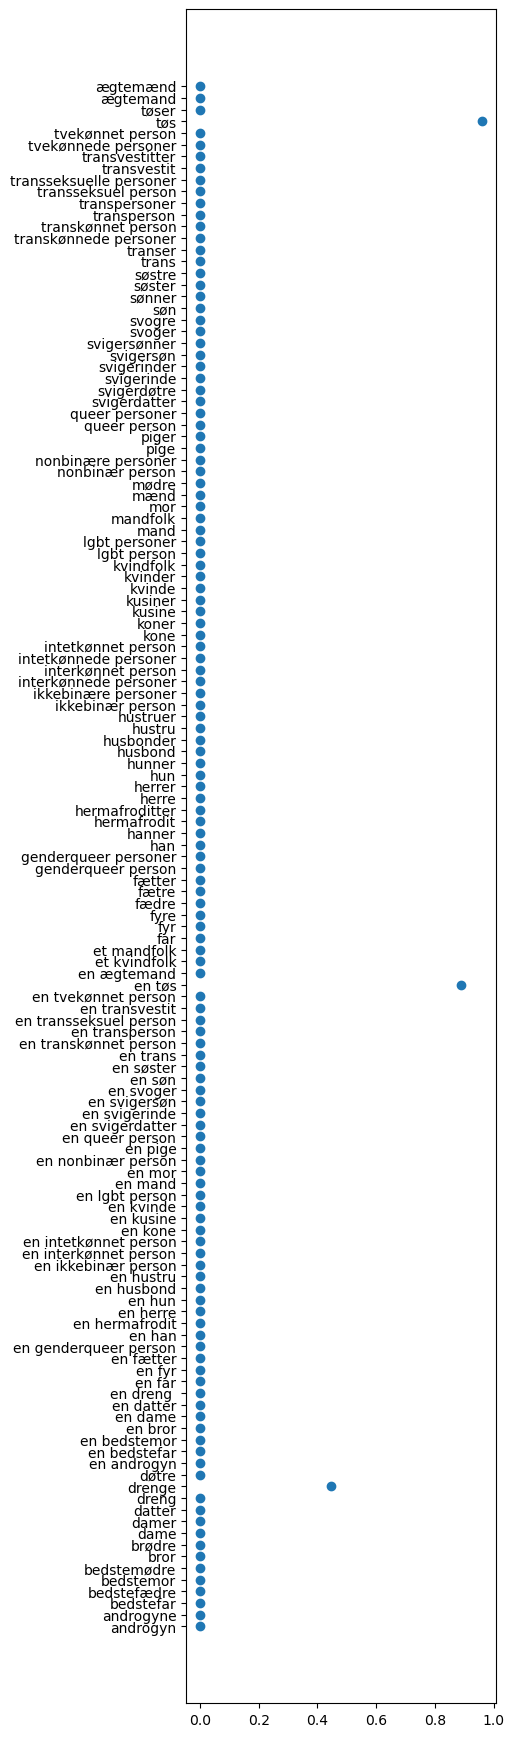

In [173]:
y = fprs.keys()
x = fprs.values()
plt.figure(figsize=(4,22))
plt.scatter(x, y)
plt.show()

In [182]:
overall = compute_confusion_rates(y_actual=synth_data['toxic'], y_pred=synth_data['pred'])
sum(abs(overall['fpr'] - fpr_t) for fpr_t in fprs.values())

4.042316118935834

In [187]:
# now calculate per-term fnr

g = synth_data.groupby('identity_term')
fnrs = dict()
for i in g:
    g_name = i[0]
    g_df = i[1]
    
    #print(g_name)
    #print(confusion_matrix(g_df['toxic'], g_df['pred']))
    #print(compute_confusion_counts(y_actual=g_df['toxic'], y_pred=g_df['pred']))
    
    g_confusion_rates = compute_confusion_rates(y_actual=g_df['toxic'], y_pred=g_df['pred'])
    #print(g_confusion_rates)
    fnrs[g_name] = g_confusion_rates['fnr']
fnrs

{'androgyn': 0.88,
 'androgyne': 0.8681318681318682,
 'bedstefar': 0.88,
 'bedstefædre': 0.8681318681318682,
 'bedstemor': 0.88,
 'bedstemødre': 0.8681318681318682,
 'bror': 1.0,
 'brødre': 0.978021978021978,
 'dame': 1.0,
 'damer': 0.9230769230769231,
 'datter': 0.96,
 'dreng': 0.88,
 'drenge': 0.2637362637362637,
 'døtre': 0.945054945054945,
 'en androgyn': 0.9230769230769231,
 'en bedstefar': 0.9230769230769231,
 'en bedstemor': 0.9230769230769231,
 'en bror': 1.0,
 'en dame': 1.0,
 'en datter': 0.9230769230769231,
 'en dreng ': 0.9230769230769231,
 'en far': 1.0,
 'en fyr': 0.9230769230769231,
 'en fætter': 1.0,
 'en genderqueer person': 1.0,
 'en han': 0.9230769230769231,
 'en hermafrodit': 0.9230769230769231,
 'en herre': 1.0,
 'en hun': 0.9230769230769231,
 'en husbond': 0.9230769230769231,
 'en hustru': 0.9230769230769231,
 'en ikkebinær person': 1.0,
 'en interkønnet person': 1.0,
 'en intetkønnet person': 1.0,
 'en kone': 0.9615384615384616,
 'en kusine': 1.0,
 'en kvinde': 0

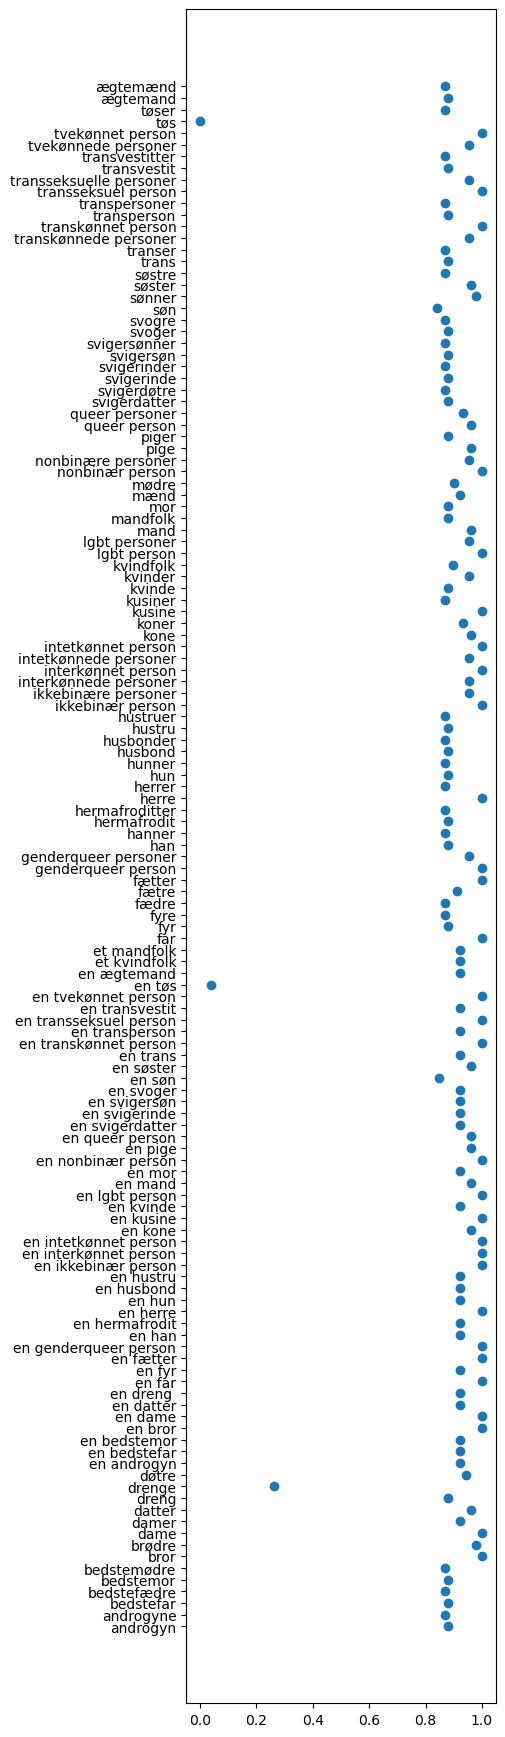

In [191]:
y = fnrs.keys()
x = fnrs.values()
plt.figure(figsize=(4,22))
plt.scatter(x, y)
plt.show()

In [188]:
sum(abs(overall['fnr'] - fnr_t) for fnr_t in fnrs.values())

8.724579555138067